# XGBoost - RETAIL DEMAND PREDICTION

We will use XGBoost. It tends to overfit quickly so we will also tune hyperparameters carefully in order to avoid this. Here we will tune the following parameters:

* **N_ESTIMATORS**: Number of trees to fit
* **MAX_DEPTH**: Maximum tree depth for base learners
* **GAMMA**: Minimum loss reduction required to make a further partition on a leaf node of the tree.
* **MIN_CHILD_WEIGHT**: Minimum sum of instance weight needed in a child.
* **SUBSAMPLE**: Subsample ratio of the training instance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from datetime import timedelta

from sklearn.metrics import mean_squared_log_error as msle

In [2]:
df = pd.read_csv('final_data.csv')
df.shape

(232265, 58)

In [3]:
df.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MONTH,MANUFACTURER_1,MANUFACTURER_2,...,week,quarter,U_MANUFACTURER,U_CATEGORY,U_SUB_CATEGORY,UNITS_BEFORE_52WEEK,price_difference,2_MONTH_BEFORE,1_WEEK_BEFORE,AVERAGE_UNITS_IN_2_MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1,1,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0
1,2009-01-14,367,1111009497,1.39,0,0,20,1,1,0,...,3,1,4,3,5,0.0,0.0,2008-11-12,2009-01-07,0.0


In [4]:
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])

In [5]:
df.dtypes

WEEK_END_DATE                datetime64[ns]
STORE_NUM                             int64
UPC                                   int64
BASE_PRICE                          float64
FEATURE                               int64
DISPLAY                               int64
UNITS                                 int64
MONTH                                 int64
MANUFACTURER_1                        int64
MANUFACTURER_2                        int64
MANUFACTURER_3                        int64
MANUFACTURER_4                        int64
MANUFACTURER_5                        int64
MANUFACTURER_6                        int64
MANUFACTURER_7                        int64
MANUFACTURER_8                        int64
MANUFACTURER_9                        int64
CATEGORY_1                            int64
CATEGORY_2                            int64
CATEGORY_3                            int64
CATEGORY_4                            int64
SUB_CATEGORY_1                        int64
SUB_CATEGORY_2                  

In [6]:
df.drop(columns = ['2_MONTH_BEFORE', '1_WEEK_BEFORE'], axis = 1, inplace = True)

In [7]:
df.isnull().sum().sum()

0

## 1. Validation Sets
* **validation_df** function will create the validation sets.
* It will take the parameters, a list of unique WEEK_END_DATES, dataset and no of months in training period and no of training validation sets required.
* We will use the training period of 1 month and 9 validation sets as concluded by the Validation Strategy

In [8]:
weeks = df['WEEK_END_DATE'].unique()

In [9]:
def validation_df(data, week, no_of_months=1, no_of_validations=1):
    
    model_set = []
    set_n = 1
    
    for w in range(len(week)-1, 0, -1):
        
        x_data = {}
        
        x_data['set_no'] = 'set'+str(set_n)
        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['validation_week'] = week[w-2]
        x_data['test_week'] = week[w]
                
        set_n += 1
        model_set.append(x_data)
        if (len(model_set) == no_of_validations):
            break
    
    
#===========================================================================================================


    datapoints = []
    
    for s in model_set:
        
        x = {}
        train_set = data[(data['WEEK_END_DATE'] >= s['train_start']) & (data['WEEK_END_DATE'] <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape'] = data[data['WEEK_END_DATE'] == s['validation_week']].shape[0]
        x['test_shape'] = data[data['WEEK_END_DATE'] == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)
        
    strategy_df = pd.DataFrame(datapoints)
    strategy_df['no_days_train'] = strategy_df['no_days_train'] + timedelta(days = 7)
    
    return strategy_df

In [10]:
validation_df(df, weeks, no_of_months=1, no_of_validations=9)

,train_shape,validation_shape,test_shape,set_no,train_start,train_end,no_days_train,validation_week,test_week
0,6538,1640,1642,set1,2011-08-10,2011-08-31,28 days,2011-09-14,2011-09-28
1,6549,1632,1638,set2,2011-08-03,2011-08-24,28 days,2011-09-07,2011-09-21
2,6546,1629,1640,set3,2011-07-27,2011-08-17,28 days,2011-08-31,2011-09-14
3,6543,1640,1632,set4,2011-07-20,2011-08-10,28 days,2011-08-24,2011-09-07
4,6551,1638,1629,set5,2011-07-13,2011-08-03,28 days,2011-08-17,2011-08-31
5,6553,1631,1640,set6,2011-07-06,2011-07-27,28 days,2011-08-10,2011-08-24
6,6555,1640,1638,set7,2011-06-29,2011-07-20,28 days,2011-08-03,2011-08-17
7,6558,1637,1631,set8,2011-06-22,2011-07-13,28 days,2011-07-27,2011-08-10
8,6558,1635,1640,set9,2011-06-15,2011-07-06,28 days,2011-07-20,2011-08-03


* We will create a list **(evaluation_set)** of tuples. These tuples will contain train and validation data extracted using the validation dataframe.
* We will use the columns **train_start, train_end** and **validate_week** and filter out the data which lies in that training period and validation period.
* We will define a function **get_evaluation_sets** to get the required list of tuples.

In [11]:
def get_evaluation_set(data):
    
    evaluation_set = []
    
    for r in range(data.shape[0]):
        row = data.iloc[r]
        print(row['validation_week'])
        
        # get train_data
        train_data = df[(df['WEEK_END_DATE'] >= row['train_start']) & (df['WEEK_END_DATE'] <= row['train_end'])]
        # get validation_data
        valid_data = df[df['WEEK_END_DATE'] == row['validation_week']]
        
        evaluation_set.append((train_data, valid_data))
        
    return evaluation_set
        

In [12]:
evaluation_sets = get_evaluation_set(validation_df(df, weeks, no_of_months=1, no_of_validations=9))

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00


* Now, We will define one function to calculate the RMSLE **get_msle** 
* We will define a custom evaluation metric function **custom_eval** for the XGBoost Regressor. This metric will calculate the RMSLE. This is because, XGBoost does not have it internally defined.

In [13]:
# Function to get RMSLE
def get_rmsle(true, predicted):
    return np.sqrt(msle(true, predicted))

# Function to get a custom evalueation metric for XGBoost
def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = preds.clip(min=0)
    
    return[('rmsle', get_rmsle(labels, preds))]

### 1. N_ESTIMATORS
* We cannot use the function XGBoost.cv to find out the best set of parameters as it randomly splits the data. Here we have a time series data so we will use the same 9 validation sets and take average.
* We will track both the train RMSLE and validation RMSLE for **n estimators** ranging between (20, 400) and check the scores on all the 9 validation sets.

In [14]:
def get_n_estimators(evaluation_set, min_r, max_r):
    
    results = []
    
    for n_est in range(min_r, max_r, 20):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # seperate the independent and target variable from the train and validation set
            train_data_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_data_y = combo[0]['UNITS']
            
            valid_data_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_data_y = combo[1]['UNITS']
            
            e_set = [(train_data_x, train_data_y), (valid_data_x, valid_data_y)]
            
            model = xgb.XGBRegressor(n_estimators = n_est,
                                    learning_rate = 0.01,
                                    n_jobs = 4,
                                    random_state = 0,
                                    objective = 'reg:squarederror')
            
            model.fit(train_data_x, train_data_y, eval_metric = custom_eval, eval_set = e_set, verbose = False)
            
            # store the RMSLE on train and validation sets in different lists 
            # so that at the end we can calculate the mean of results at the end 
            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
            
        print('With n_estimators:\t' + str(n_est) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
            
        x['n_estimators'] = n_est
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
            
        results.append(x)
        
    return pd.DataFrame(results)

In [15]:
n_estimators_result = get_n_estimators(evaluation_sets ,min_r = 20, max_r = 400)

With n_estimators:	20	Mean_RMSLE_Train:	1.3765283333333334	Mean_RMSLE_Valid:	1.3517786666666667
With n_estimators:	40	Mean_RMSLE_Train:	0.957999111111111	Mean_RMSLE_Valid:	0.9476348888888888
With n_estimators:	60	Mean_RMSLE_Train:	0.7316607777777778	Mean_RMSLE_Valid:	0.7371152222222223
With n_estimators:	80	Mean_RMSLE_Train:	0.5946118888888888	Mean_RMSLE_Valid:	0.6163743333333334
With n_estimators:	100	Mean_RMSLE_Train:	0.5084737777777778	Mean_RMSLE_Valid:	0.5461411111111111
With n_estimators:	120	Mean_RMSLE_Train:	0.4539968888888889	Mean_RMSLE_Valid:	0.5057314444444445
With n_estimators:	140	Mean_RMSLE_Train:	0.41988122222222224	Mean_RMSLE_Valid:	0.48354922222222224
With n_estimators:	160	Mean_RMSLE_Train:	0.3984118888888889	Mean_RMSLE_Valid:	0.4719898888888889
With n_estimators:	180	Mean_RMSLE_Train:	0.385004	Mean_RMSLE_Valid:	0.4666703333333333
With n_estimators:	200	Mean_RMSLE_Train:	0.3766998888888889	Mean_RMSLE_Valid:	0.46481533333333336
With n_estimators:	220	Mean_RMSLE_Train:	0

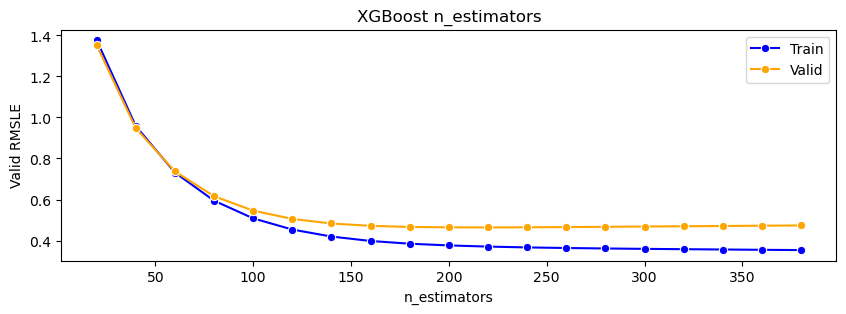

In [19]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x = n_estimators_result['n_estimators'], y = n_estimators_result['mean_rmsle_train'], marker = 'o', color= 'blue', label= 'Train')
sns.lineplot(x = n_estimators_result['n_estimators'], y = n_estimators_result['mean_rmsle_valid'], marker = 'o', color= 'orange', label= 'Valid')
plt.title('XGBoost n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Valid RMSLE')
plt.show()

For the **n_estimators** value of 220, RMSLE on the validation set is minimum **(0.4642)** and as we increase n_estimators, RMSLE starts increasing again. So we will fix the n_estimators as 220.

### 2. MAX_DEPTH
* Next very important hyperparameter to be tuned is Max Depth. This is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
* Now, we will check the performance of the model for various max_depth values 2, 3, ....14.
* If the performance keeps improving till max_depth 14, we will increase the values and try again.

In [20]:
def get_max_depth(evaluation_set):
    
    results = []
    
    for depth in range(2, 15, 1):
        
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            train_x = combo[0].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            train_y = combo[0]['UNITS']
            
            valid_x = combo[1].drop(columns = ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
            valid_y = combo[1]['UNITS']
            
            e_set = [(train_x, train_y),(valid_x, valid_y)]
            
            model = xgb.XGBRegressor(n_estimators = 220,
                                    max_depth = depth,
                                    learning_rate = 0.01,
                                    n_jobs = 4,
                                    random_state = 0,
                                    objective = 'reg:squarederror')
            model.fit(train_x, train_y, eval_metric = custom_eval, eval_set = e_set, verbose = False)
            
            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With DEPTH:\t'+ str(depth) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+ '\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['depth']= depth
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
        
    return pd.DataFrame(results)

In [21]:
max_depth_results = get_max_depth(evaluation_sets)

With DEPTH:	2	MEAN RMSLE TRAIN:	0.5237873333333334	MEAN RMSLE VALID: 0.5480940000000001
With DEPTH:	3	MEAN RMSLE TRAIN:	0.46084477777777777	MEAN RMSLE VALID: 0.5007481111111112
With DEPTH:	4	MEAN RMSLE TRAIN:	0.422998	MEAN RMSLE VALID: 0.47866344444444436
With DEPTH:	5	MEAN RMSLE TRAIN:	0.39488511111111113	MEAN RMSLE VALID: 0.467857
With DEPTH:	6	MEAN RMSLE TRAIN:	0.37102977777777774	MEAN RMSLE VALID: 0.4642932222222222
With DEPTH:	7	MEAN RMSLE TRAIN:	0.3481923333333334	MEAN RMSLE VALID: 0.4645974444444444
With DEPTH:	8	MEAN RMSLE TRAIN:	0.32533588888888887	MEAN RMSLE VALID: 0.4666935555555556
With DEPTH:	9	MEAN RMSLE TRAIN:	0.3010454444444444	MEAN RMSLE VALID: 0.46914666666666666
With DEPTH:	10	MEAN RMSLE TRAIN:	0.2756890000000001	MEAN RMSLE VALID: 0.47255877777777777
With DEPTH:	11	MEAN RMSLE TRAIN:	0.250243	MEAN RMSLE VALID: 0.47600855555555555
With DEPTH:	12	MEAN RMSLE TRAIN:	0.2265542222222222	MEAN RMSLE VALID: 0.48175299999999993
With DEPTH:	13	MEAN RMSLE TRAIN:	0.205138444444444

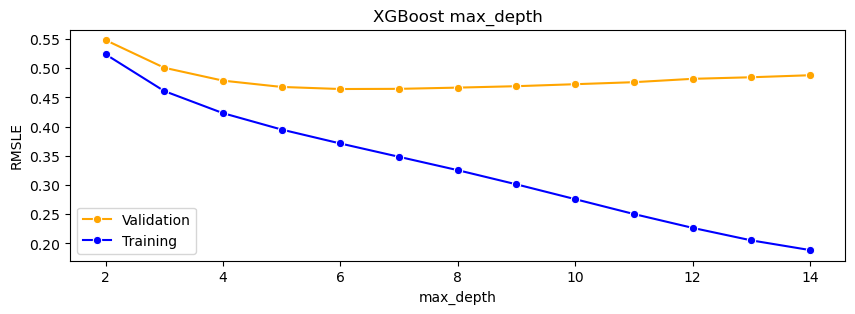

In [22]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x = max_depth_results['depth'], y = max_depth_results['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
sns.lineplot(x = max_depth_results['depth'], y = max_depth_results['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
plt.title('XGBoost max_depth')
plt.xlabel('max_depth')
plt.ylabel('RMSLE')
plt.show()

* We can see that the model starts overfitting after **max_depth = 6** as it is improving only on train data. RMSLE at this value of max_depth is **0.4642**


### 3. MIN_CHILD_WEIGHT
* min_child_weight is another parameter to control overfitting. The larger min_child_weight is, the more bias the algorithm has.
* We will check the performance of the model for the values 1 to 5.
* The value of n_estimators will be 200 and max_depth will be 4.

In [23]:
def get_min_child_weight(evaluation_set):
    
    results = []
    
    for mcw in (range(1, 6, 1)):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        for combo in evaluation_set:
                        
            # separate the independent and target variables from the train and valid data.    
            train_data_x = combo[0].drop(columns= ['WEEK_END_DATE', 'UNITS', 'STORE_NUM', 'UPC'])
            train_data_y = combo[0]['UNITS']

            valid_data_x = combo[1].drop(columns= ['WEEK_END_DATE', 'UNITS', 'STORE_NUM', 'UPC'])
            valid_data_y = combo[1]['UNITS']
            
            
            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [(train_data_x, train_data_y),(valid_data_x, valid_data_y)]

            model = xgb.XGBRegressor(n_estimators = 220,
                                     max_depth=6,
                                     min_child_weight= mcw,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
            
        # calculate the mean rmsle on train and valid     
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With Min Child Weight:\t'+ str(mcw) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+ '\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['mcw'] = mcw
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame(results)

In [24]:
mcw_results = get_min_child_weight(evaluation_sets)

With Min Child Weight:	1	MEAN RMSLE TRAIN:	0.37102977777777774	MEAN RMSLE VALID: 0.4642932222222222
With Min Child Weight:	2	MEAN RMSLE TRAIN:	0.37116044444444446	MEAN RMSLE VALID: 0.4645636666666666
With Min Child Weight:	3	MEAN RMSLE TRAIN:	0.3713246666666667	MEAN RMSLE VALID: 0.4646906666666667
With Min Child Weight:	4	MEAN RMSLE TRAIN:	0.37133544444444444	MEAN RMSLE VALID: 0.4643035555555556
With Min Child Weight:	5	MEAN RMSLE TRAIN:	0.37159622222222216	MEAN RMSLE VALID: 0.46447655555555556


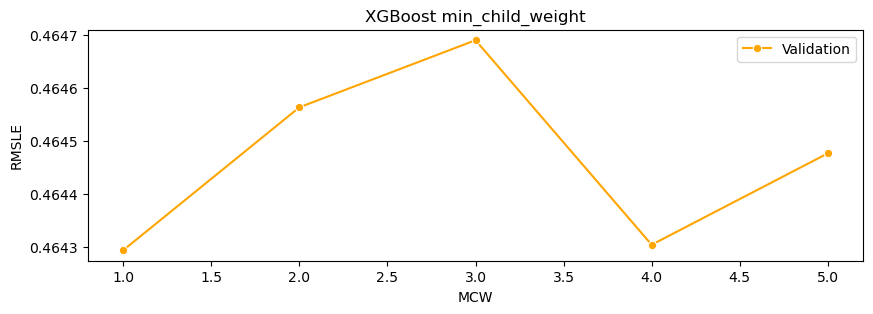

In [25]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x = mcw_results['mcw'], y = mcw_results['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
#sns.lineplot(x = mcw_results['mcw'], y = mcw_results['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
plt.title('XGBoost min_child_weight')
plt.xlabel('MCW')
plt.ylabel('RMSLE')
plt.show()

* The values of min_child_weight doesn't make much difference to the model performance. However at **min_child_weight = 1** the RMSLE **(0.4642)** for training and validation sets both, is lowest. So we will keep this value as 3.

### 4. GAMMA
* A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. The larger gamma is, the more biased the algorithm will be.
* We will check the performance of the model on values 0, 0.01, 0.1, 0.5, 1, 10 and 100.


In [35]:
def get_gamma(evaluation_set):
    
    results = []
    
    for g in [0, 0.01, 0.1, 0.5, 1, 10, 100]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
                        
            # separate the target and independent variables from the train and valid    
            train_data_x = combo[0].drop(columns= ['WEEK_END_DATE', 'UNITS', 'STORE_NUM', 'UPC'])
            train_data_y = combo[0]['UNITS']

            valid_data_x = combo[1].drop(columns= ['WEEK_END_DATE', 'UNITS', 'STORE_NUM', 'UPC'])
            valid_data_y = combo[1]['UNITS']

            
            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [ (train_data_x, train_data_y), (valid_data_x, valid_data_y)]

            # fit the model 
            model = xgb.XGBRegressor(n_estimators = 220,
                                     max_depth=6,
                                     min_child_weight= 1,
                                     gamma=g,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
            
        # calculate the mean rmsle on train and valid.    
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With Gamma:\t'+ str(g) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+'\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['gamma'] = g
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame(results)

In [36]:
gamma_results = get_gamma(evaluation_sets)

With Gamma:	0	MEAN RMSLE TRAIN:	0.37102977777777774	MEAN RMSLE VALID: 0.4642932222222222
With Gamma:	0.01	MEAN RMSLE TRAIN:	0.37102977777777774	MEAN RMSLE VALID: 0.4642932222222222
With Gamma:	0.1	MEAN RMSLE TRAIN:	0.37102977777777774	MEAN RMSLE VALID: 0.4642932222222222
With Gamma:	0.5	MEAN RMSLE TRAIN:	0.3710245555555556	MEAN RMSLE VALID: 0.4643196666666667
With Gamma:	1	MEAN RMSLE TRAIN:	0.3710257777777778	MEAN RMSLE VALID: 0.46441444444444446
With Gamma:	10	MEAN RMSLE TRAIN:	0.3709841111111111	MEAN RMSLE VALID: 0.4643756666666667
With Gamma:	100	MEAN RMSLE TRAIN:	0.3712566666666667	MEAN RMSLE VALID: 0.46446566666666667


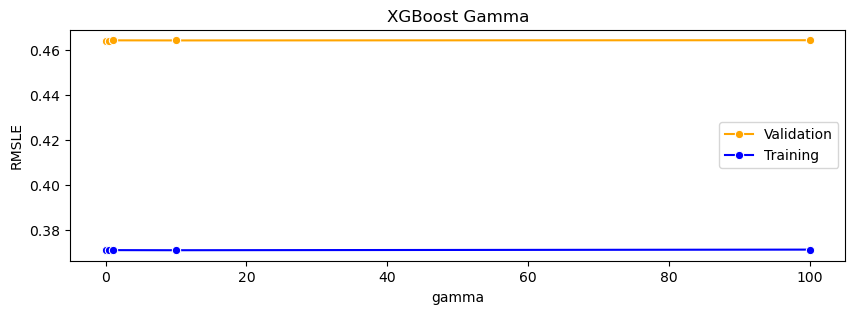

In [38]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x = gamma_results['gamma'], y = gamma_results['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
sns.lineplot(x = gamma_results['gamma'], y = gamma_results['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
plt.title('XGBoost Gamma')
plt.xlabel('gamma')
plt.ylabel('RMSLE')
plt.show()

* The value of gamma is also not making much difference to the model performance.
* We will keep the value of gamma fixed to 0.

### 5. SUB SAMPLE
* Subsample ratio of the training instances. Setting it to a value less than 1 means that XGBoost would randomly sample a percentage of the training data prior to growing trees and this will prevent overfitting.
* We will choose different values from 0 to 1 and check the performance.

In [39]:
def get_subsample(evaluation_set):
    
    results = []
    
    for ss in [ 0.01, 0.05, 0.075, 0.1, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.999, 1]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for combo in evaluation_set:
            
            # separate the independent and target variable from train and valid
            train_data_x = combo[0].drop(columns= ['WEEK_END_DATE', 'UNITS', 'STORE_NUM', 'UPC'])
            train_data_y = combo[0]['UNITS']

            valid_data_x = combo[1].drop(columns= ['WEEK_END_DATE', 'UNITS', 'STORE_NUM', 'UPC'])
            valid_data_y = combo[1]['UNITS']

            # evaluation sets
            # we will evaluate our model on both train and validation data
            e_set = [ (train_data_x, train_data_y), (valid_data_x, valid_data_y)]

            # fit the model
            model = xgb.XGBRegressor(n_estimators = 220,
                                     subsample= ss,
                                     max_depth= 6,
                                     min_child_weight= 3,
                                     gamma= 0,
                                     learning_rate=0.01,
                                     n_jobs=4,
                                     random_state=0,
                                     objective='reg:squarederror')
            
            model.fit(train_data_x, train_data_y, eval_metric= custom_eval ,eval_set= e_set, verbose=False)

            SCORE_TRAIN.append(model.evals_result_['validation_0']['rmsle'][-1])
            SCORE_VALID.append(model.evals_result_['validation_1']['rmsle'][-1])
            
        # calculate the mean rmsle on train and valid.
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print('With Subsample:\t'+ str(ss) + '\tMEAN RMSLE TRAIN:\t' + str(mean_score_train)+'\tMEAN RMSLE VALID: '+str(mean_score_valid))
        x['sub_sample'] = ss
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)

    return pd.DataFrame(results)

In [40]:
subsample_results = get_subsample(evaluation_sets)

With Subsample:	0.01	MEAN RMSLE TRAIN:	0.44329266666666667	MEAN RMSLE VALID: 0.4913100000000001
With Subsample:	0.05	MEAN RMSLE TRAIN:	0.39475311111111105	MEAN RMSLE VALID: 0.4660103333333334
With Subsample:	0.075	MEAN RMSLE TRAIN:	0.386328	MEAN RMSLE VALID: 0.46217811111111107
With Subsample:	0.1	MEAN RMSLE TRAIN:	0.38241733333333333	MEAN RMSLE VALID: 0.4601707777777778
With Subsample:	0.4	MEAN RMSLE TRAIN:	0.37012355555555554	MEAN RMSLE VALID: 0.4614125555555556
With Subsample:	0.6	MEAN RMSLE TRAIN:	0.36914355555555556	MEAN RMSLE VALID: 0.46296977777777776
With Subsample:	0.7	MEAN RMSLE TRAIN:	0.3693183333333333	MEAN RMSLE VALID: 0.4626851111111111
With Subsample:	0.8	MEAN RMSLE TRAIN:	0.3694411111111111	MEAN RMSLE VALID: 0.4637271111111111
With Subsample:	0.9	MEAN RMSLE TRAIN:	0.3696728888888889	MEAN RMSLE VALID: 0.4642157777777778
With Subsample:	0.95	MEAN RMSLE TRAIN:	0.3702341111111111	MEAN RMSLE VALID: 0.46467588888888894
With Subsample:	0.97	MEAN RMSLE TRAIN:	0.3704831111111111

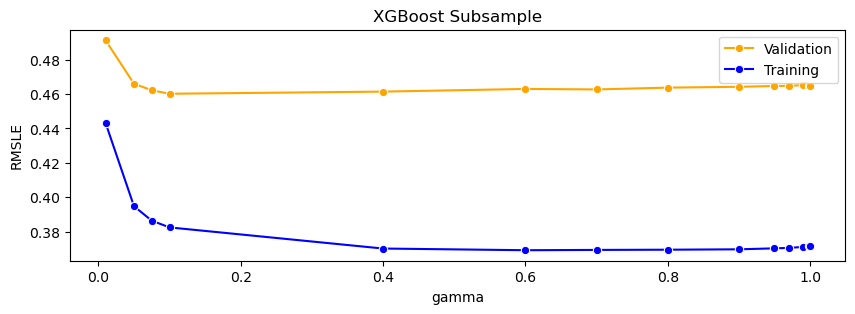

In [41]:
plt.figure(figsize = (10,3), dpi = 100)
sns.lineplot(x = subsample_results['sub_sample'], y = subsample_results['mean_rmsle_valid'], marker = 'o', color = 'orange', label = 'Validation')
sns.lineplot(x = subsample_results['sub_sample'], y = subsample_results['mean_rmsle_train'], marker = 'o', color = 'blue', label = 'Training')
plt.title('XGBoost Subsample')
plt.xlabel('gamma')
plt.ylabel('RMSLE')
plt.show()

* We can see that the **Lowest RMSLE (0.4601)** is at the **subsample = 0.1**

#### Final Hyperparameters
So after all the steps for tuning the hyperparameters for XGBoost, this is what we have.

* **N_ESTIMATORS** : 220
* **MAX_DEPTH** : 6
* **LEARNING RATE** : 0.01
* **GAMMA** : 0
* **MIN_CHILD_WEIGHT** : 1
* **SUBSAMPLE** : 0.1